# Comparison plots among different combinations.
### Comparing Speedup achieved with THIN and EPYC nodes.
We want to compare the speedup achieved using EPYC and THIN nodes for cores scalability.
To avoid having a cluttered graph we will only have a look at results obtained with double precision using close policy (since close and spread do not change that much).

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os

current_directory = os.getcwd()
print("Current Working Directory:", current_directory) # To reset wd to default one

Current Working Directory: /Users/samuele/Documents/Università/Magistrale/Corsi/HPC/FHPC_Assignment/Exercise2


In [65]:
pl = 'close'
prec = 'double'
nodes = ['EPYC', 'THIN']
methods = ['oblas', 'mkl', 'blis']


df = pd.DataFrame(columns=['n_threads', 'Time', 'GFLOPS', 'precision', 'method', 'placement', 'node'])
df

for node in nodes:
    for m in methods:
        file_pattern = f"{node}/cores/{pl}/{m}_{prec}_*.csv"
        print(file_pattern)
        # Get a list of file paths matching the pattern
        file_paths = glob.glob(file_pattern)
        #print(f"file_pattern matches {len(file_paths)} paths")

        # Initialize an empty list to store DataFrames
        dfs = []

        # Loop through each file and read it into a DataFrame, then add it to the list
        for file_path in file_paths:
            df_temp = pd.read_csv(file_path)
            dfs.append(df_temp)

        # Concatenate all DataFrames in the list into a single DataFrame
        df_temp = pd.concat(dfs, ignore_index=True)
        df_temp['precision'] = prec
        df_temp['method'] = m
        df_temp['placement'] = pl
        df_temp['node'] = node

        # Display the combined DataFrame
        df = pd.concat([df, df_temp])

EPYC/cores/close/oblas_double_*.csv
EPYC/cores/close/mkl_double_*.csv
EPYC/cores/close/blis_double_*.csv
THIN/cores/close/oblas_double_*.csv
THIN/cores/close/mkl_double_*.csv
THIN/cores/close/blis_double_*.csv


In [66]:
df = df[df['n_threads']<=24]
df

,n_threads,Time,GFLOPS,precision,method,placement,node
0,4,10.800171,185.182261,double,oblas,close,EPYC
1,4,10.787388,185.401700,double,oblas,close,EPYC
2,4,10.774600,185.621738,double,oblas,close,EPYC
3,4,10.790497,185.348280,double,oblas,close,EPYC
4,4,10.806560,185.072776,double,oblas,close,EPYC
...,...,...,...,...,...,...,...
115,18,3.152241,634.469161,double,blis,close,THIN
116,18,3.153275,634.261105,double,blis,close,THIN
117,18,3.158075,633.297159,double,blis,close,THIN
118,18,3.143414,636.250920,double,blis,close,THIN


In [67]:
df.drop(columns=['precision'])

grouped_double = df.groupby(['method', 'placement', 'n_threads', 'node'])
agg_df = grouped_double['Time'].agg(['mean', 'std']).reset_index()
agg_df

,method,placement,n_threads,node,mean,std
0,blis,close,1,EPYC,45.447519,1.180212
1,blis,close,1,THIN,50.223577,0.072987
2,blis,close,2,EPYC,21.318371,0.064761
3,blis,close,2,THIN,25.664324,0.046880
4,blis,close,3,THIN,16.986070,0.154974
...,...,...,...,...,...,...
106,oblas,close,22,EPYC,2.492972,0.003337
107,oblas,close,22,THIN,1.496540,0.020445
108,oblas,close,23,THIN,1.489639,0.068407
109,oblas,close,24,EPYC,2.312632,0.004361


In [68]:
def calculate_speedup(group):
    group['speedup'] =  group['mean'].iloc[0] / group['mean']
    return group

agg_df2 = agg_df.groupby(['method', 'placement', 'node'], group_keys=False).apply(calculate_speedup).reset_index(drop=True)
agg_df2 = agg_df2.sort_values(['node', 'method', 'placement'])
agg_df2

,method,placement,n_threads,node,mean,std,speedup
0,blis,close,1,EPYC,45.447519,1.180212,1.000000
2,blis,close,2,EPYC,21.318371,0.064761,2.131848
5,blis,close,4,EPYC,11.694933,0.023829,3.886086
8,blis,close,6,EPYC,8.163526,0.031397,5.567143
11,blis,close,8,EPYC,5.836877,0.034538,7.786274
...,...,...,...,...,...,...,...
104,oblas,close,20,THIN,1.600844,0.005603,18.200134
105,oblas,close,21,THIN,1.531890,0.007589,19.019370
107,oblas,close,22,THIN,1.496540,0.020445,19.468622
108,oblas,close,23,THIN,1.489639,0.068407,19.558813


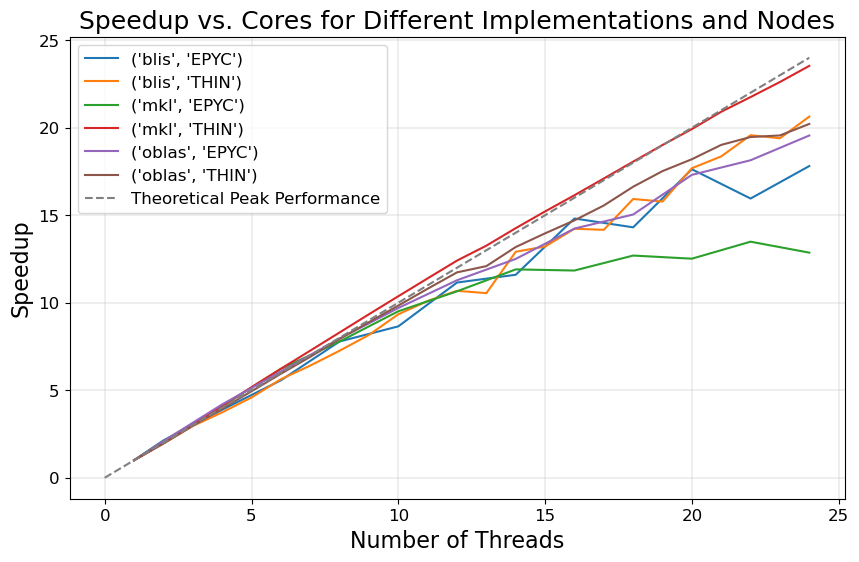

In [69]:
# Create a figure and axis
agg_df.drop(columns=['placement'])
plt.figure(figsize=(10, 6))
for name, group in agg_df2.groupby(['method',  'node']):
    nope = name
    plt.plot(group['n_threads'], group['speedup'], label=name)
# Add labels and legend
# Add labels and title

x_values = np.arange(0, 26, 2)
plt.plot(x_values, x_values, c = "gray", linestyle="dashed", label="Theoretical Peak Performance")

plt.xlabel('Number of Threads', fontsize = 16)
plt.ylabel('Speedup', fontsize = 16)
plt.title('Speedup vs. Cores for Different Implementations and Nodes', fontsize = 18)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.grid(linewidth = 0.3)
plt.show()


In [70]:
grouped_double = df.groupby(['method', 'placement', 'n_threads', 'node'])
agg_df = grouped_double['GFLOPS'].agg(['mean', 'std']).reset_index()
agg_df

,method,placement,n_threads,node,mean,std
0,blis,close,1,EPYC,44.029774,1.105773
1,blis,close,1,THIN,39.822002,0.057951
2,blis,close,2,EPYC,93.816489,0.284362
3,blis,close,2,THIN,77.929397,0.142281
4,blis,close,3,THIN,117.751288,1.061978
...,...,...,...,...,...,...
106,oblas,close,22,EPYC,802.256611,1.073948
107,oblas,close,22,THIN,1336.613964,18.115744
108,oblas,close,23,THIN,1344.793031,59.520082
109,oblas,close,24,EPYC,864.817880,1.633226


# Analysis of the results obtained using modified code with parallelisation

In [71]:
methods = ['oblas', 'mkl', 'blis']
precisions = ['double', 'float']

df = pd.DataFrame(columns=['Size', 'Time', 'GFLOPS', 'precision', 'parallel_init']) 
df


for prec in precisions:
    for m in methods:
        file_pattern = f"modified/close/{m}_{prec}_.csv"
        print(file_pattern)
    
        df_temp = pd.read_csv(file_pattern)
        df_temp['precision'] = prec
        df_temp['method'] = m
        df_temp['parallel_init'] = True

        # Display the combined DataFrame
        df = pd.concat([df, df_temp])

modified/close/oblas_double_.csv
modified/close/mkl_double_.csv
modified/close/blis_double_.csv
modified/close/oblas_float_.csv
modified/close/mkl_float_.csv
modified/close/blis_float_.csv


/var/folders/tv/ysw0jsvs2t331mtk7hdh35kc0000gn/T/ipykernel_1269/4165042640.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, df_temp])
/var/folders/tv/ysw0jsvs2t331mtk7hdh35kc0000gn/T/ipykernel_1269/4165042640.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, df_temp])
/var/folders/tv/ysw0jsvs2t331mtk7hdh35kc0000gn/T/ipykernel_1269/4165042640.py:19: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, df_temp])
/var/folders/tv/ysw0jsvs2t331mtk7hdh35kc0000gn/T/ipykernel_1269/4165042640.py:19: FutureWarning: In a future version, object-dtype columns 

In [72]:
# READ THE OLD ONES BEFORE ALLOCATION
for prec in precisions:
    for m in methods:
        file_pattern = f"EPYC/size/close/{m}_{prec}*.csv"
        file_paths = glob.glob(file_pattern)
        dfs = []

        for file_path in file_paths:
            df_temp = pd.read_csv(file_path)
            dfs.append(df_temp)

        df_temp = pd.concat(dfs, ignore_index=True)
        df_temp['precision'] = prec
        df_temp['method'] = m
        df_temp['parallel_init'] = False

        # Display the combined DataFrame
        df = pd.concat([df, df_temp])

/var/folders/tv/ysw0jsvs2t331mtk7hdh35kc0000gn/T/ipykernel_1269/1626942713.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, df_temp])
/var/folders/tv/ysw0jsvs2t331mtk7hdh35kc0000gn/T/ipykernel_1269/1626942713.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, df_temp])
/var/folders/tv/ysw0jsvs2t331mtk7hdh35kc0000gn/T/ipykernel_1269/1626942713.py:18: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = pd.concat([df, df_temp])
/var/folders/tv/ysw0jsvs2t331mtk7hdh35kc0000gn/T/ipykernel_1269/1626942713.py:18: FutureWarning: In a future version, object-dtype columns 

In [73]:
df

,Size,Time,GFLOPS,precision,parallel_init,method
0,2000,0.025596,625.099894,double,True,oblas
1,2000,0.029533,541.775734,double,True,oblas
2,2000,0.027353,584.943995,double,True,oblas
3,2000,0.026611,601.261808,double,True,oblas
4,2000,0.028221,566.954591,double,True,oblas
...,...,...,...,...,...,...
90,7000,0.416967,1645.212563,float,False,blis
91,7000,0.403076,1701.913451,float,False,blis
92,7000,0.404148,1697.399226,float,False,blis
93,7000,0.409012,1677.211154,float,False,blis


In [75]:
df_double = df[df['precision']=='double']
agg_df = df_double.groupby(['method', 'precision', 'Size', 'parallel_init'])
agg_df = agg_df['GFLOPS'].agg(['mean', 'std']).reset_index()
agg_df

,method,precision,Size,parallel_init,mean,std
0,blis,double,2000,False,625.576368,34.717671
1,blis,double,2000,True,660.110821,34.765988
2,blis,double,3000,False,980.311087,11.418383
3,blis,double,3000,True,998.275133,15.784696
4,blis,double,4000,False,991.792594,11.977142
...,...,...,...,...,...,...
109,oblas,double,18000,True,1615.778915,11.521001
110,oblas,double,19000,False,929.514678,44.027892
111,oblas,double,19000,True,1682.512190,16.222436
112,oblas,double,20000,False,1065.411505,105.089746


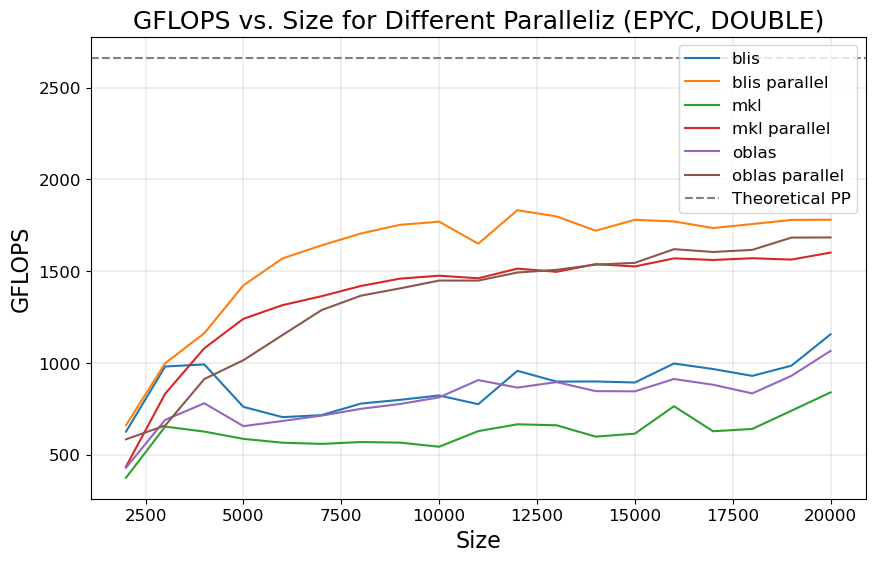

In [76]:
# Create a figure and axis
plt.figure(figsize=(10, 6))
for name, group in agg_df.groupby(['method',  'precision', 'parallel_init']):
    if(name[2]):
        label_ = name[0] + ' parallel'
    else:
        label_ = name[0]

    plt.plot(group['Size'], group['mean'], label=label_)


plt.xlabel('Size', fontsize = 16)
plt.ylabel('GFLOPS', fontsize = 16)
plt.title('GFLOPS vs. Size for Different Paralleliz (EPYC, DOUBLE)', fontsize = 18)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.axhline(y = 2.6*16*64, color = 'gray', label = "Theoretical PP", linestyle='dashed')

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.grid(linewidth = 0.3)
plt.show()

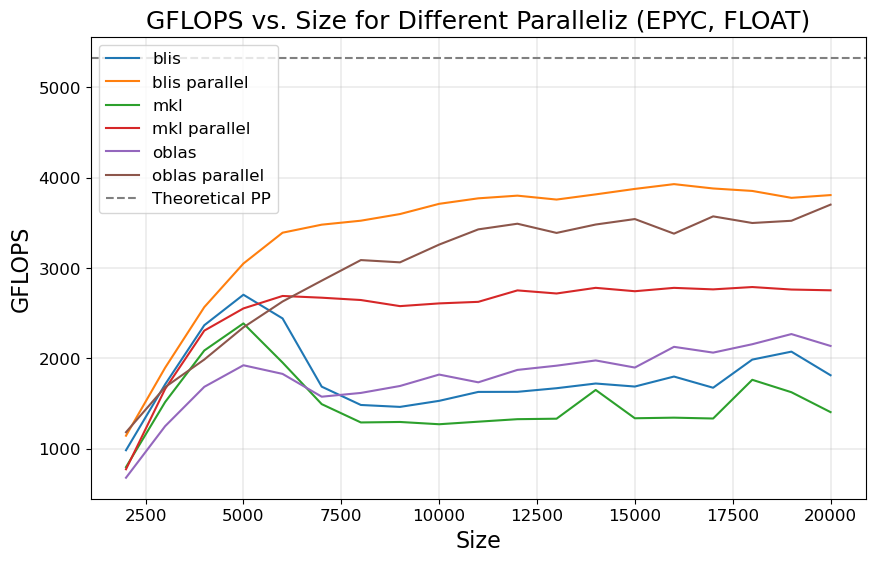

In [77]:
df
df_float = df[df['precision']=='float']
agg_df = df_float.groupby(['method', 'precision', 'Size', 'parallel_init'])
agg_df = agg_df['GFLOPS'].agg(['mean', 'std']).reset_index()
agg_df
# Create a figure and axis
plt.figure(figsize=(10, 6))
for name, group in agg_df.groupby(['method',  'precision', 'parallel_init']):
    if(name[2]):
        label_ = name[0] + ' parallel'
    else:
        label_ = name[0]

    plt.plot(group['Size'], group['mean'], label=label_)


plt.xlabel('Size', fontsize = 16)
plt.ylabel('GFLOPS', fontsize = 16)
plt.title('GFLOPS vs. Size for Different Paralleliz (EPYC, FLOAT)', fontsize = 18)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.axhline(y = 2.6*32*64, color = 'gray', label = "Theoretical PP", linestyle='dashed')

# Add legend
plt.legend(fontsize=12)

# Show the plot
plt.grid(linewidth = 0.3)
plt.show()
